# Лабораторна робота №4: Моделі класифікації та їх оцінка

### Мета роботи

Ознайомитися з основними моделями класифікації, а також навчитися оцінювати якість класифікаторів за різноманітними метриками.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1. Завантаження даних

Завантажте набори даних "Airline Passenger Satisfaction" для навчання (`train.csv`) та тестування (`test.csv`)  з [Kaggle](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction) або з Google Classroom.

In [10]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### 2. Обробка набору даних

1. З набору даних видаліть наступні стовпці:
    * `"Unnamed: 0"`
    * `"id"`
2. Заповніть всі пусті значення у наборі даних значенням `0`.
3. Перетворіть стовпці рядкових значень на стовпці, що мають числові значення.
4. Нормалізуйте значення кожної ознаки моделі.

_У наборі даних кожен зі стовпчиків є ознакою моделі, окрім останнього під назвою `"satisfaction"`, який є цільовою змінною._

In [11]:
columns_to_drop = ["Unnamed: 0", "id"]
train_df.drop(columns=columns_to_drop, inplace=True)
test_df.drop(columns=columns_to_drop, inplace=True)

In [13]:
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

In [21]:
# Типи стовпців у train_df
print("Типи стовпців у train_df:")
print(train_df.dtypes)

# Типи стовпців у test_df
print("\nТипи стовпців у test_df:")
print(test_df.dtypes)

Типи стовпців у train_df:
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes     

In [22]:
from sklearn.preprocessing import LabelEncoder

# Створення об'єкта LabelEncoder
le = LabelEncoder()

# Зберігаємо кількість рядків у train_df для подальшого розділення
train_len = len(train_df)

# Об'єднуємо train_df і test_df
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Застосовуємо One-Hot Encoding до категоріальних стовпців
categorical_cols = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
combined_df = pd.get_dummies(combined_df, columns=categorical_cols)

# Застосовуємо Label Encoding до стовпця 'satisfaction'
combined_df['satisfaction'] = le.fit_transform(combined_df['satisfaction'])

# Розділяємо назад на train_df і test_df
train_df = combined_df.iloc[:train_len, :]
test_df = combined_df.iloc[train_len:, :]

# Виведення перших кількох рядків оновлених DataFrame для підтвердження (опціонально)
print("Перші 5 рядків оновленого train_df:")
print(train_df.head())
print("\nПерші 5 рядків оновленого test_df:")
print(test_df.head())

# Виведення типів стовпців оновлених DataFrame (опціонально)
print("\nТипи стовпців оновленого train_df:")
print(train_df.dtypes)
print("\nТипи стовпців оновленого test_df:")
print(test_df.dtypes)

Перші 5 рядків оновленого train_df:
   Age  Flight Distance  Inflight wifi service   
0   13              460                      3  \
1   25              235                      3   
2   26             1142                      2   
3   25              562                      2   
4   61              214                      3   

   Departure/Arrival time convenient  Ease of Online booking  Gate location   
0                                  4                       3              1  \
1                                  2                       3              3   
2                                  2                       2              2   
3                                  5                       5              5   
4                                  3                       3              3   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  ...   
0               5                3             5                       5  ...  \
1               1         

In [24]:
from sklearn.preprocessing import MinMaxScaler

# Створюємо об'єкт MinMaxScaler
scaler = MinMaxScaler()

# Визначаємо числові стовпці (всі стовпці, крім 'satisfaction', якщо вона є цільовою змінною)
numerical_cols_train = train_df.columns.drop('satisfaction', errors='ignore')
numerical_cols_test = test_df.columns.drop('satisfaction', errors='ignore')

# Навчаємо масштабувальник на числових стовпцях train_df
scaler.fit(train_df[numerical_cols_train])

# Перетворюємо числові стовпці в train_df
train_df.loc[:, numerical_cols_train] = scaler.transform(train_df[numerical_cols_train])

# Перетворюємо числові стовпці в test_df, використовуючи той самий навчений масштабувальник
test_df.loc[:, numerical_cols_test] = scaler.transform(test_df[numerical_cols_test])

# Виведення перших кількох рядків оновлених DataFrame для підтвердження (опціонально)
print("Перші 5 рядків нормалізованого train_df:")
print(train_df.head())
print("\nПерші 5 рядків нормалізованого test_df:")
print(test_df.head())

Перші 5 рядків нормалізованого train_df:
        Age  Flight Distance  Inflight wifi service   
0  0.076923         0.086632                    0.6  \
1  0.230769         0.041195                    0.6   
2  0.243590         0.224354                    0.4   
3  0.230769         0.107229                    0.4   
4  0.692308         0.036955                    0.6   

   Departure/Arrival time convenient  Ease of Online booking  Gate location   
0                                0.8                     0.6            0.2  \
1                                0.4                     0.6            0.6   
2                                0.4                     0.4            0.4   
3                                1.0                     1.0            1.0   
4                                0.6                     0.6            0.6   

   Food and drink  Online boarding  Seat comfort  Inflight entertainment  ...   
0             1.0              0.6           1.0                     1.0

### 3. Навчання моделей

Натренуйте кожну з моделей:

* Наївний баєсів класифікатор [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
* Дерево рішень [Decision Tree](https://scikit-learn.org/stable/modules/tree.html)
* Логістична регресія [Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)
* K-найближчі сусідів [K-Nearest Neighbors](https://scikit-learn.org/stable/modules/neighbors.html)
* Випадковий ліс [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles)

_Для кожної з моделей також підрахуйте час виконання у мілісекундах, це буде необхідно для виконання 4-го завдання._

### 4. Підрахунок основних метрик

Для кожної з моделей підрахуйте наступні метрики:

* [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
* [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)
* [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html)
* [F1-Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
* Швидкість виконання (у мс.)

Отримані дані запишіть у `DataFrame` та візуалізуйте його у вигляді таблиці. Також можете додати до `DataFrame` `.style.background_gradient(cmap='Greens')`, що дозволить краще візуально порівнювати значення у кожному зі стовпчиків.

In [25]:
from sklearn.model_selection import train_test_split

# Виділення ознак (X) та цільової змінної (y)
X = train_df.drop('satisfaction', axis=1)
y = train_df['satisfaction']

# Розділення на тренувальний та валідаційний набори (опціонально, але рекомендується для оцінки)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Імпорт необхідних бібліотек для моделей
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import time

# Створення словника для зберігання навчених моделей та часу їх навчання
trained_models = {}
training_times = {}

# 1. Наївний баєсів класифікатор (Naive Bayes)
start_time = time.time()
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train, y_train)
end_time = time.time()
training_time_nb = (end_time - start_time) * 1000  # Час у мілісекундах
trained_models['Naive Bayes'] = naive_bayes_model
training_times['Naive Bayes'] = training_time_nb
print(f"Навчання Naive Bayes зайняло: {training_time_nb:.2f} мс")

# 2. Дерево рішень (Decision Tree)
start_time = time.time()
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train, y_train)
end_time = time.time()
training_time_dt = (end_time - start_time) * 1000
trained_models['Decision Tree'] = decision_tree_model
training_times['Decision Tree'] = training_time_dt
print(f"Навчання Decision Tree зайняло: {training_time_dt:.2f} мс")

# 3. Логістична регресія (Logistic Regression)
start_time = time.time()
logistic_regression_model = LogisticRegression(random_state=42, solver='liblinear', max_iter=1000)
logistic_regression_model.fit(X_train, y_train)
end_time = time.time()
training_time_lr = (end_time - start_time) * 1000
trained_models['Logistic Regression'] = logistic_regression_model
training_times['Logistic Regression'] = training_time_lr
print(f"Навчання Logistic Regression зайняло: {training_time_lr:.2f} мс")

# 4. K-найближчі сусіди (K-Nearest Neighbors)
start_time = time.time()
knn_model = KNeighborsClassifier(n_neighbors=5)  # Можна налаштувати кількість сусідів
knn_model.fit(X_train, y_train)
end_time = time.time()
training_time_knn = (end_time - start_time) * 1000
trained_models['K-Nearest Neighbors'] = knn_model
training_times['K-Nearest Neighbors'] = training_time_knn
print(f"Навчання K-Nearest Neighbors зайняло: {training_time_knn:.2f} мс")

# 5. Випадковий ліс (Random Forest)
start_time = time.time()
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100) # Можна налаштувати кількість дерев
random_forest_model.fit(X_train, y_train)
end_time = time.time()
training_time_rf = (end_time - start_time) * 1000
trained_models['Random Forest'] = random_forest_model
training_times['Random Forest'] = training_time_rf
print(f"Навчання Random Forest зайняло: {training_time_rf:.2f} мс")

print("\nНавчені моделі:", list(trained_models.keys()))
print("Час навчання кожної моделі (мс):", training_times)

Навчання Naive Bayes зайняло: 59.52 мс
Навчання Decision Tree зайняло: 673.78 мс
Навчання Logistic Regression зайняло: 1062.62 мс
Навчання K-Nearest Neighbors зайняло: 17.28 мс
Навчання Random Forest зайняло: 12323.11 мс

Навчені моделі: ['Naive Bayes', 'Decision Tree', 'Logistic Regression', 'K-Nearest Neighbors', 'Random Forest']
Час навчання кожної моделі (мс): {'Naive Bayes': 59.51881408691406, 'Decision Tree': 673.7837791442871, 'Logistic Regression': 1062.6163482666016, 'K-Nearest Neighbors': 17.283201217651367, 'Random Forest': 12323.107719421387}


### 5. Візуалізація матриць невідповідностей

Для кожної з моделей візуалізуйте [матрицю невідповідності](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

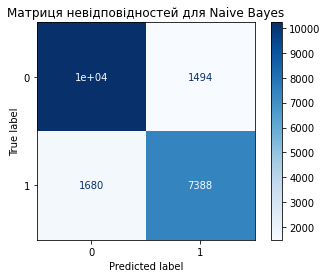

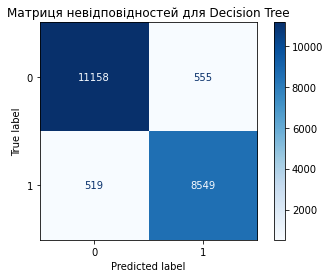

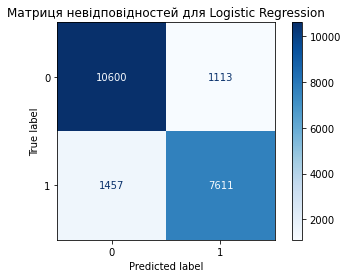

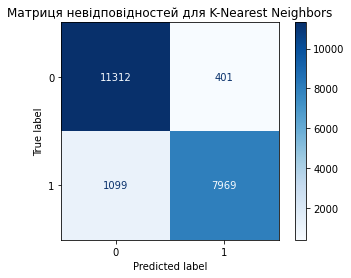

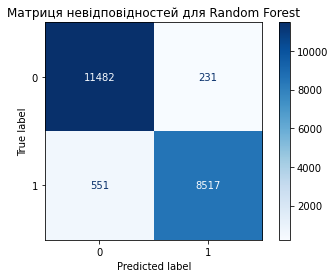

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Класифікатори, які ми навчили
model_names = list(trained_models.keys())
models = list(trained_models.values())

# Візуалізація матриць невідповідностей для кожної моделі
for name, model in zip(model_names, models):
    # Отримання передбачень на валідаційному наборі
    y_pred = model.predict(X_val)

    # Обчислення матриці невідповідностей
    cm = confusion_matrix(y_val, y_pred)

    # Візуалізація матриці невідповідностей
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Матриця невідповідностей для {name}')
    plt.show()

In [35]:
!python3 -m pip show pytorch-tabnet

Name: pytorch-tabnet
Version: 4.1.0
Summary: PyTorch implementation of TabNet
Home-page: https://github.com/dreamquark-ai/tabnet
Author: 
Author-email: 
License: 
Location: /home/hoksly/.local/lib/python3.10/site-packages
Requires: numpy, scikit_learn, scipy, torch, tqdm
Required-by: 


In [36]:
# Переконайтеся, що у вас встановлено pytorch та pytorch-tabnet
# pip install torch torchvision torchaudio
# pip install pytorch-tabnet

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from pytorch_tabnet.tab_model import TabNetClassifier # Спробуйте цей імпорт
import torch

# Припустимо, що train_df вже попередньо оброблено (заповнені NaN, закодовані категоріальні ознаки)
# Якщо ні, вам потрібно виконати ці кроки

# Виділення ознак (X) та цільової змінної (y)
X = train_df.drop('satisfaction', axis=1).values
y = train_df['satisfaction'].values

# Перетворення цільової змінної на числові мітки, якщо це ще не зроблено
le = LabelEncoder()
y = le.fit_transform(y)

# Розділення даних на тренувальний та валідаційний набори
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Ініціалізація класифікатора TabNet
tabnet_model = TabNetClassifier(
    n_steps=1,  # Кількість кроків в архітектурі TabNet
    optimizer_fn=torch.optim.Adam,
    lr=0.01,
    gamma=0.9,
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    scheduler_params={"mode": "min", "patience": 5, "factor": 0.5},
    verbose=1  # Виводити інформацію про навчання
)

# Навчання моделі
tabnet_model.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=['auc', 'accuracy'], # Ви можете вибрати інші метрики
    max_epochs=10  # Кількість епох навчання
)

# Отримання передбачень на валідаційному наборі
y_pred = tabnet_model.predict(X_val)

# Побудова матриці невідповідностей
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,

SyntaxError: incomplete input (8497702.py, line 55)